# Predicting Food Delivery Time

## Exploratory Data Analysis (EDA)

### 1. Load the dataset, handle any missing/Nan values and encode the categorical features using an appropriate method.

#### Loading and handling missing/Nan Values

In [3]:
import pandas as pd

data = pd.read_csv('data/Food_Delivery_Times.csv')


print(data.isnull().sum())


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


In [4]:
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [5]:
numerical_columns

Index(['Order_ID', 'Distance_km', 'Preparation_Time_min',
       'Courier_Experience_yrs', 'Delivery_Time_min'],
      dtype='object')

In [6]:
categorical_columns

Index(['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], dtype='object')

In [7]:
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

In [8]:
data[categorical_columns] = data[categorical_columns].fillna('Unknown') # need to think, if I should use something like Mode of the column?


#### Encoding Categorical Features

In [9]:
data_categorical = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [10]:
data_categorical

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Unknown,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Traffic_Level_Unknown,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_Unknown,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,1.0,43,False,False,False,False,True,True,False,False,False,False,False,False,False,True
1,738,16.42,20,2.0,84,False,False,False,False,False,False,True,False,True,False,False,False,False,False
2,741,9.52,28,1.0,59,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,661,7.44,5,1.0,37,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,412,19.03,16,5.0,68,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,107,8.50,13,3.0,54,False,False,False,False,False,False,False,False,True,False,False,False,True,False
996,271,16.28,8,9.0,71,False,True,False,False,False,True,False,False,False,True,False,False,False,True
997,861,15.62,26,2.0,81,False,False,True,False,False,False,False,False,True,False,False,False,False,True
998,436,14.17,8,0.0,55,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [11]:
data[data["Order_ID"] == 313]

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
42,313,0.99,Unknown,Medium,Evening,Bike,15,4.579381,32


### 2. Plot histograms, boxplots, violin plots, etc. for the features (choose plots based on type of feature). State your observations/insights.

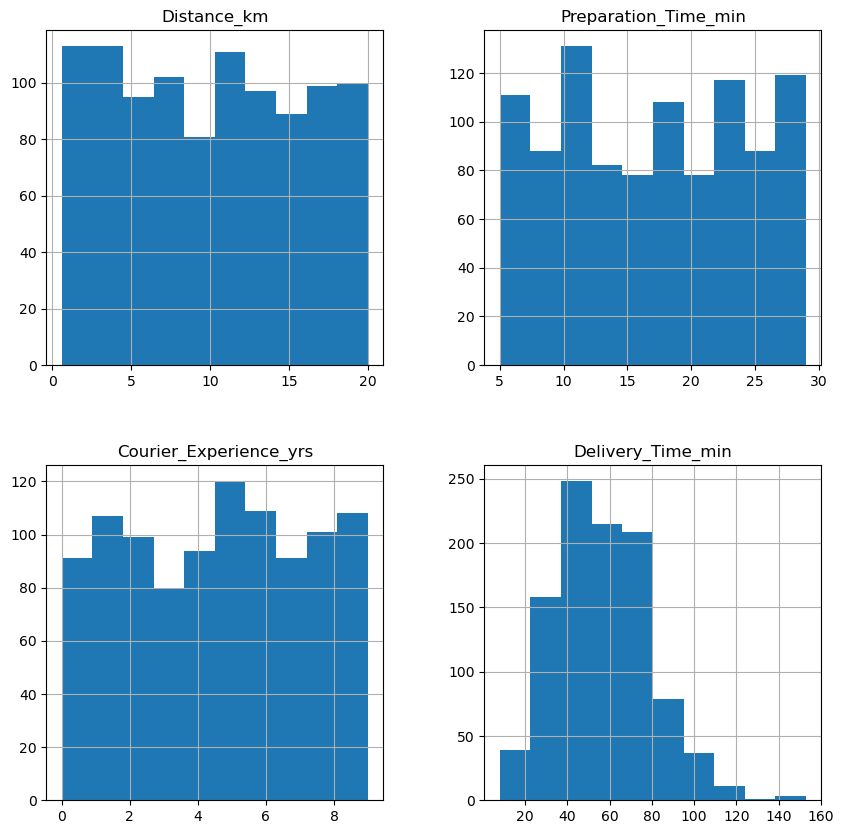

In [12]:
import matplotlib.pyplot as plt

excluded_column = 'Order_ID'
data_without_order_id = data.drop(columns=[excluded_column])

data_without_order_id.hist(figsize=(10, 10))
plt.show()

### 3. Split the dataset into train, test and validation sets (70:15:15 split) and scale the features

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# data[categorical_columns] = data[categorical_columns].fillna(
#     data[categorical_columns].mode().iloc[0]
# )

X = data_categorical.drop('Delivery_Time_min', axis=1)
y = data_categorical['Delivery_Time_min']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # (training) + (test + validation)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # (test) + (validation)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print("Training set shape:", X_train_scaled.shape, y_train.shape)
print("Validation set shape:", X_val_scaled.shape, y_val.shape)
print("Test set shape:", X_test_scaled.shape, y_test.shape)


Training set shape: (700, 18) (700,)
Validation set shape: (150, 18) (150,)
Test set shape: (150, 18) (150,)


## Linear Regression with Gradient Descent

In [14]:
from icecream import ic

In [25]:
import numpy as np
import random

DEFAULT_SCALE = 1

def initialise_weights_and_bias(num_params: int, scale: float, method: str = "random"):
    if method == "random":
        weights = np.random.random(num_params * scale)
        bias = random.random() * scale

    elif method == "zeroes":
        weights = np.zeroes(num_params)
        bias = 0

    return weights, bias

def predict(X, w, b):
    return np.dot(X, w) + b

def compute_loss_and_gradients(X, y, weights, bias):
    num_datapoints = len(y)

    y_pred = predict(X, weights, bias)

    loss = np.mean((y - y_pred) ** 2)

    grad_w = -(2 / num_datapoints) * np.dot(X.T, (y - y_pred))
    grad_b = -(2 / num_datapoints) * np.sum(y - y_pred)  #### NEED TO SEE THIS <----------------

    return loss, grad_w, grad_b

def stochastic_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    num_params = len(X[0]) # the number of params in the first row
    num_datapoints = len(y)

    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    learning_rate = 0.01

    training_losses = []
    validation_losses = []

    num_iterations = 1

    for iter in range(num_iterations):
        # ic(iter)
        for i in range(num_datapoints):
            # ic(i)
            one_x = X[i: i + 1]
            corresponding_y_to_one_x = y[i: i + 1]

            loss, grad_w, grad_b = compute_loss_and_gradients(one_x, corresponding_y_to_one_x, w, b)

            grad_w = np.array(grad_w, dtype=np.float64)
            grad_b = np.array(grad_b, dtype=np.float64)


            # ic(loss, grad_w, grad_b)
            # ic(learning_rate * grad_w)
            # ic(w)
            # ic(type(learning_rate * grad_w))
            # ic(type(w))

            w -= learning_rate * grad_w
            b -= learning_rate * grad_b


            training_losses.append(loss)

        # validate and then put the loss in the array
        validation_loss, ignore1, ignore2 = compute_loss_and_gradients(X_val, y_val, w, b)

        validation_losses.append(validation_loss)

    return w, b, training_losses, validation_losses

def batch_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    num_params = len(X[0])
    
    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    num_iterations = 10

    learning_rate = 0.01

    training_losses = []
    validation_losses = []

    for iter in range(num_iterations):
        loss, grad_w, grad_b = compute_loss_and_gradients(X, y, w, b)
        
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        training_losses.append(loss)
        
        val_loss, _, _ = compute_loss_and_gradients(X_val, y_val, w, b)
        validation_losses.append(val_loss)

    return w, b, training_losses, validation_losses

def mini_batch_gd(X: list, y: list, X_val: list, y_val: list, init_method: str = "random") -> tuple:
    num_params = len(X[0])
    
    w, b = initialise_weights_and_bias(num_params, DEFAULT_SCALE, init_method)

    num_iterations = 10
    training_losses = []
    validation_losses = []

    learning_rate = 0.01

    # should I divide them in equal groups of batch-size length or should I randomly take batch-size number of elements
    # shuffle here (do remember)
    
    batch_size = 32

    batches_X = X.reshape(-1, batch_size)
    batches_y = y.reshape(-1, batch_size)

    num_batches = len(batches_X)

    for iter in range(num_iterations):
        for batch in range(num_batches):
            loss, grad_w, grad_b = compute_loss_and_gradients(batches_X[batch], batches_y[batch], w, b)

            w -= learning_rate * grad_w
            b -= learning_rate * grad_b

            training_losses.append(loss)
            
        val_loss, _, _ = compute_loss_and_gradients(X_val, y_val, w, b)
        validation_losses.append(val_loss)

    return w, b, training_losses, validation_losses

def plot_results(method, training_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    
    plt.plot(training_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='red')
    
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve for {method}')
    plt.legend()
    
    plt.show()

def do2_2(init_method):
    # test-train split
    ########################## Might need to do a shuffling here ############################
    X_train, X_val, X_test = X[:700], X[700:850], X[850:]
    y_train, y_val, y_test = y[:700], y[700:850], y[850:]
    
    # I think it'll be better if I convert this to an np array
    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

    init_method = "random"

    # stochastic
    w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)

    # batch
    w_batch, b_batch, training_losses_batch, validation_losses_batch = batch_gd(X_train, y_train, X_val, y_val, init_method)

    # mini-batch
    w_mini_batch, b_mini_batch, training_losses_mini_batch, validation_losses_mini_batch = mini_batch_gd(X_train, y_train, X_val, y_val, init_method)


Test for stochastic

In [26]:
X_train, X_val, X_test = X[:700], X[700:850], X[850:]
y_train, y_val, y_test = y[:700], y[700:850], y[850:]

In [27]:
X_train

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Unknown,Weather_Windy,Traffic_Level_Low,Traffic_Level_Medium,Traffic_Level_Unknown,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_Unknown,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,1.0,False,False,False,False,True,True,False,False,False,False,False,False,False,True
1,738,16.42,20,2.0,False,False,False,False,False,False,True,False,True,False,False,False,False,False
2,741,9.52,28,1.0,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,661,7.44,5,1.0,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,412,19.03,16,5.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,263,3.23,17,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
696,611,1.27,25,9.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False
697,298,4.71,20,6.0,False,False,False,False,False,True,False,False,False,True,False,False,False,False
698,415,12.82,28,9.0,False,True,False,False,False,False,True,False,True,False,False,False,False,False


In [28]:
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [29]:
print(X_train)

[[522 7.93 12 ... False False True]
 [738 16.42 20 ... False False False]
 [741 9.52 28 ... False False True]
 ...
 [298 4.71 20 ... False False False]
 [415 12.82 28 ... False False False]
 [151 18.21 6 ... False False False]]


In [30]:
y_train.shape

(700,)

In [31]:
init_method = "random"

# w_sgd, b_sgd, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val, init_method)
w_sgd, b_sgb, training_losses_sgd, validation_losses_sgd = stochastic_gd(X_train, y_train, X_val, y_val)

OverflowError: (34, 'Numerical result out of range')

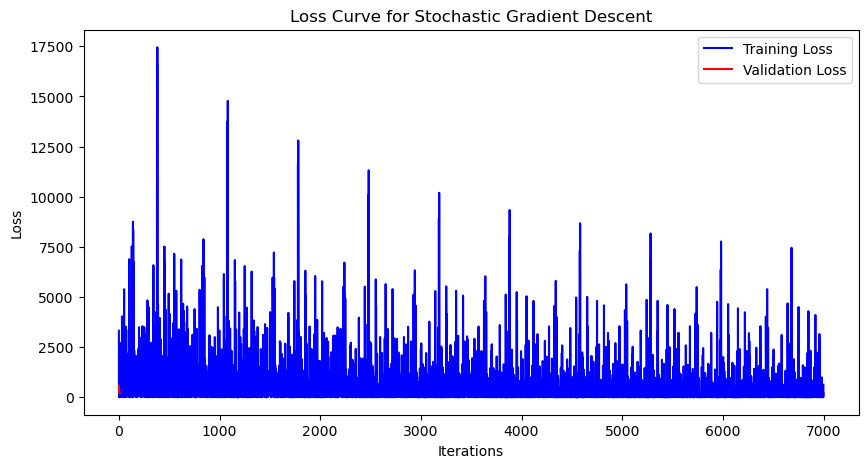

In [24]:
plot_results("Stochastic Gradient Descent", training_losses_sgd, validation_losses_sgd)